## Prepare packages

In [84]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy_withnormlayer
importlib.reload(policy_withnormlayer)
from policy_withnormlayer import PolicyNN_a

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


## Import simulation data

In [85]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all.shape

(610615, 12)

In [86]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


In [87]:
df_all = df_all.dropna()
df_all.shape

(610417, 12)

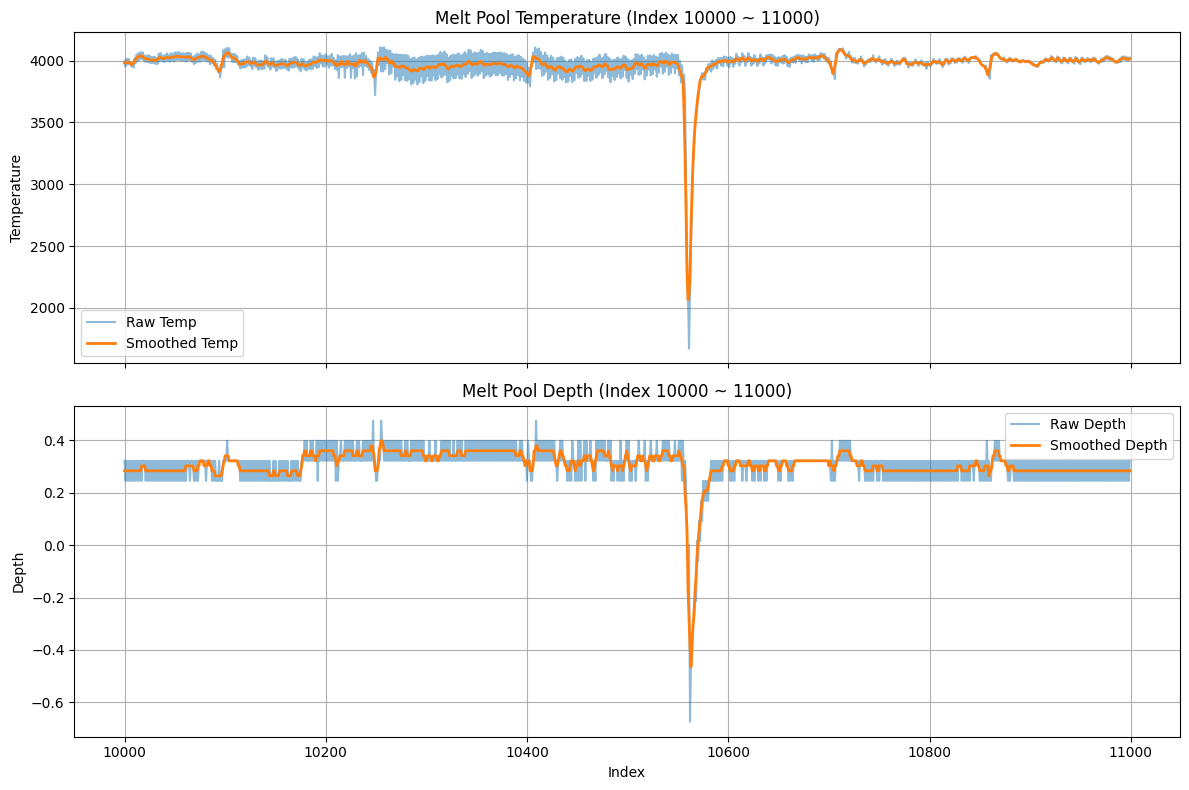

In [88]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       

# Check
start = 10000
end = 11000
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(range(start, end), mp_temp_raw[start:end], label='Raw Temp', alpha=0.5)
axes[0].plot(range(start, end), mp_temp[start:end], label='Smoothed Temp', linewidth=2)
axes[0].set_title(f"Melt Pool Temperature (Index {start} ~ {end})")
axes[0].set_ylabel("Temperature")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(start, end), mp_depth_raw[start:end], label='Raw Depth', alpha=0.5)
axes[1].plot(range(start, end), mp_depth[start:end], label='Smoothed Depth', linewidth=2)
axes[1].set_title(f"Melt Pool Depth (Index {start} ~ {end})")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Depth")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Normalize data

In [89]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

In [90]:
# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())


x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [91]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [92]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

print("x_s shape:", x_s.shape)
print("y_s shape:", y_s.shape)

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0
x_s shape: (610417, 4)
y_s shape: (610417, 2)


## Constraint 

In [93]:
length = y_s.shape[0]

# y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

e = 0.001
y_depth_low = np.random.uniform(0.075-e, 0.075+e, size=(length, 1))
y_depth_up = np.random.uniform(0.4126-e, 0.4126+e, size=(length, 1))
y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

# print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_const shape: (610417, 2)


## Data distribution

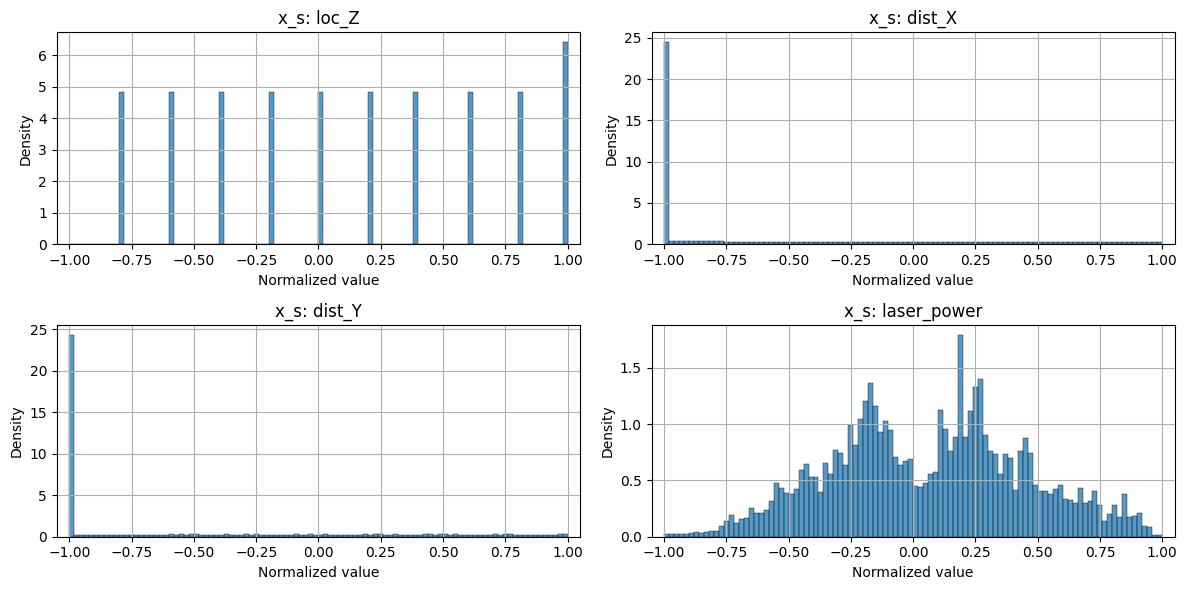

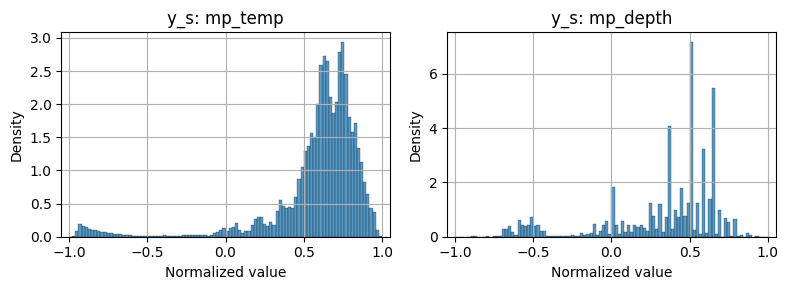

In [94]:
x_names = ['loc_Z', 'dist_X', 'dist_Y', 'laser_power']

plt.figure(figsize=(12, 6))
for i in range(x_s.shape[1]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(x_s[:, i], bins=100, binrange=(-1, 1), kde=False, stat='density')
    plt.title(f'x_s: {x_names[i]}')
    plt.xlabel('Normalized value')
    plt.ylabel('Density')
    plt.xlim(-1.05, 1.05)
    plt.grid(True)
plt.tight_layout()
plt.show()

y_names = ['mp_temp', 'mp_depth']

plt.figure(figsize=(8, 3))
for i in range(y_s.shape[1]):
    plt.subplot(1, 2, i + 1)
    sns.histplot(y_s[:, i], bins=100, binrange=(-1, 1), kde=False, stat='density')
    plt.title(f'y_s: {y_names[i]}')
    plt.xlabel('Normalized value')
    plt.ylabel('Density')
    plt.xlim(-1.05, 1.05)
    plt.grid(True)
plt.tight_layout()
plt.show()



In [95]:
# 기본 분할
cutoff_index = int(np.round(0.9 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
# y_ref_train, y_ref_val = y_s_ref[:cutoff_index], y_s_ref[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ------------------ Training set ------------------
n_train = cutoff_index - P - window
x_past_train = np.empty((n_train, window, 4))
y_past_train = np.empty((n_train, window, 2))
x_future_train = np.empty((n_train, P, 3))
y_ref_train_seq = np.empty((n_train, P, 1))
y_const_train_seq = np.empty((n_train, P, 2))

for i in tqdm(range(window, cutoff_index - P)):
    j = i - window
    x_past_train[j] = x_train[i-window:i]
    y_past_train[j] = y_train[i-window:i]
    x_future_train[j] = x_train[i:i+P, :3]         # 앞에서 3개
    y_ref_train_seq[j] = y_train[i:i+P, :1]  
    # y_ref_train_seq[j] = y_ref_train[i:i+P]
    y_const_train_seq[j] = y_const_train[i:i+P]

# ------------------ Validation set ------------------
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window
x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P)):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]
    y_ref_val_seq[j] = y_val[i:i+P, :1]  
    # y_ref_val_seq[j] = y_ref_val[i:i+P]
    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_train = torch.tensor(x_past_train, dtype=torch.float32)
y_past_train = torch.tensor(y_past_train, dtype=torch.float32)
x_future_train = torch.tensor(x_future_train, dtype=torch.float32)
y_ref_train_seq = torch.tensor(y_ref_train_seq, dtype=torch.float32)
y_const_train_seq = torch.tensor(y_const_train_seq, dtype=torch.float32)

print("x_past shape : ", x_past_train.shape)       # (n_train, 50, 4)
print("y_past shape : ",y_past_train.shape)       # (n_train, 50, 2)
print("x_future shape : ",x_future_train.shape)     # (n_train, 50, 3)
print("y_ref shape : ",y_ref_train_seq.shape)    # (n_train, 50, 1)
print("y_const shape : ",y_const_train_seq.shape)  # (n_train, 50, 2)

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

print("x_past_val shape : ", x_past_val.shape)       # (n_val, 50, 4)
print("y_past_val shape : ", y_past_val.shape)       # (n_val, 50, 2)
print("x_future_val shape : ", x_future_val.shape)   # (n_val, 50, 3)
print("y_ref_val shape : ", y_ref_val_seq.shape)     # (n_val, 50, 1)
print("y_const_val shape : ", y_const_val_seq.shape) # (n_val, 50, 2)




  3%|▎         | 19189/549275 [00:00<00:02, 191867.77it/s]

100%|██████████| 60942/60942 [00:00<00:00, 239511.24it/s]


x_past shape :  torch.Size([549275, 50, 4])
y_past shape :  torch.Size([549275, 50, 2])
x_future shape :  torch.Size([549275, 50, 3])
y_ref shape :  torch.Size([549275, 50, 1])
y_const shape :  torch.Size([549275, 50, 2])
x_past_val shape :  torch.Size([60942, 50, 4])
y_past_val shape :  torch.Size([60942, 50, 2])
x_future_val shape :  torch.Size([60942, 50, 3])
y_ref_val shape :  torch.Size([60942, 50, 1])
y_const_val shape :  torch.Size([60942, 50, 2])


## Trian / Validation data distribution

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# (이미 메모리에 로드되어 있다고 가정)
# x_past_train: torch.Tensor (n_train, window, 4)
# x_past_val:   torch.Tensor (n_val,   window, 4)
# y_past_train: torch.Tensor (n_train, window, 2)
# y_past_val:   torch.Tensor (n_val,   window, 2)

# 1) NumPy 배열로 변환
train_x0 = x_past_train[:, 0, :].cpu().numpy()  # shape (n_train, 4)
val_x0   = x_past_val[:,   0, :].cpu().numpy()  # shape (n_val, 4)
train_y0 = y_past_train[:, 0, :].cpu().numpy()  # shape (n_train, 2)
val_y0   = y_past_val[:,   0, :].cpu().numpy()  # shape (n_val, 2)

# 2) 요약 통계량 계산
features_x = ['feat1','feat2','feat3','feat4']
features_y = ['out1','out2']

stats = []
for idx, name in enumerate(features_x):
    stats.append({
        'var': name,
        'train_mean': np.mean(train_x0[:,idx]),
        'train_std':  np.std(train_x0[:,idx]),
        'train_min':  np.min(train_x0[:,idx]),
        'train_max':  np.max(train_x0[:,idx]),
        'val_mean':   np.mean(val_x0[:,idx]),
        'val_std':    np.std(val_x0[:,idx]),
        'val_min':    np.min(val_x0[:,idx]),
        'val_max':    np.max(val_x0[:,idx]),
    })
for idx, name in enumerate(features_y):
    stats.append({
        'var': name,
        'train_mean': np.mean(train_y0[:,idx]),
        'train_std':  np.std(train_y0[:,idx]),
        'train_min':  np.min(train_y0[:,idx]),
        'train_max':  np.max(train_y0[:,idx]),
        'val_mean':   np.mean(val_y0[:,idx]),
        'val_std':    np.std(val_y0[:,idx]),
        'val_min':    np.min(val_y0[:,idx]),
        'val_max':    np.max(val_y0[:,idx]),
    })

df_stats = pd.DataFrame(stats)
print(df_stats)


     var  train_mean  train_std  train_min  train_max  val_mean   val_std  \
0  feat1    0.125505   0.587513       -1.0        1.0  0.148647  0.580669   
1  feat2   -0.505175   0.641501       -1.0        1.0 -0.504680  0.641739   
2  feat3   -0.477409   0.651621       -1.0        1.0 -0.478147  0.651523   
3  feat4    0.062047   0.385799       -1.0        1.0  0.051252  0.414052   
4   out1    0.587078   0.317441       -1.0        1.0  0.588297  0.321298   
5   out2    0.323719   0.373040       -1.0        1.0  0.335735  0.374020   

    val_min   val_max  
0 -1.000000  1.000000  
1 -1.000000  1.000000  
2 -1.000000  1.000000  
3 -0.883344  0.843063  
4 -0.972395  0.933409  
5 -0.931035  0.965517  


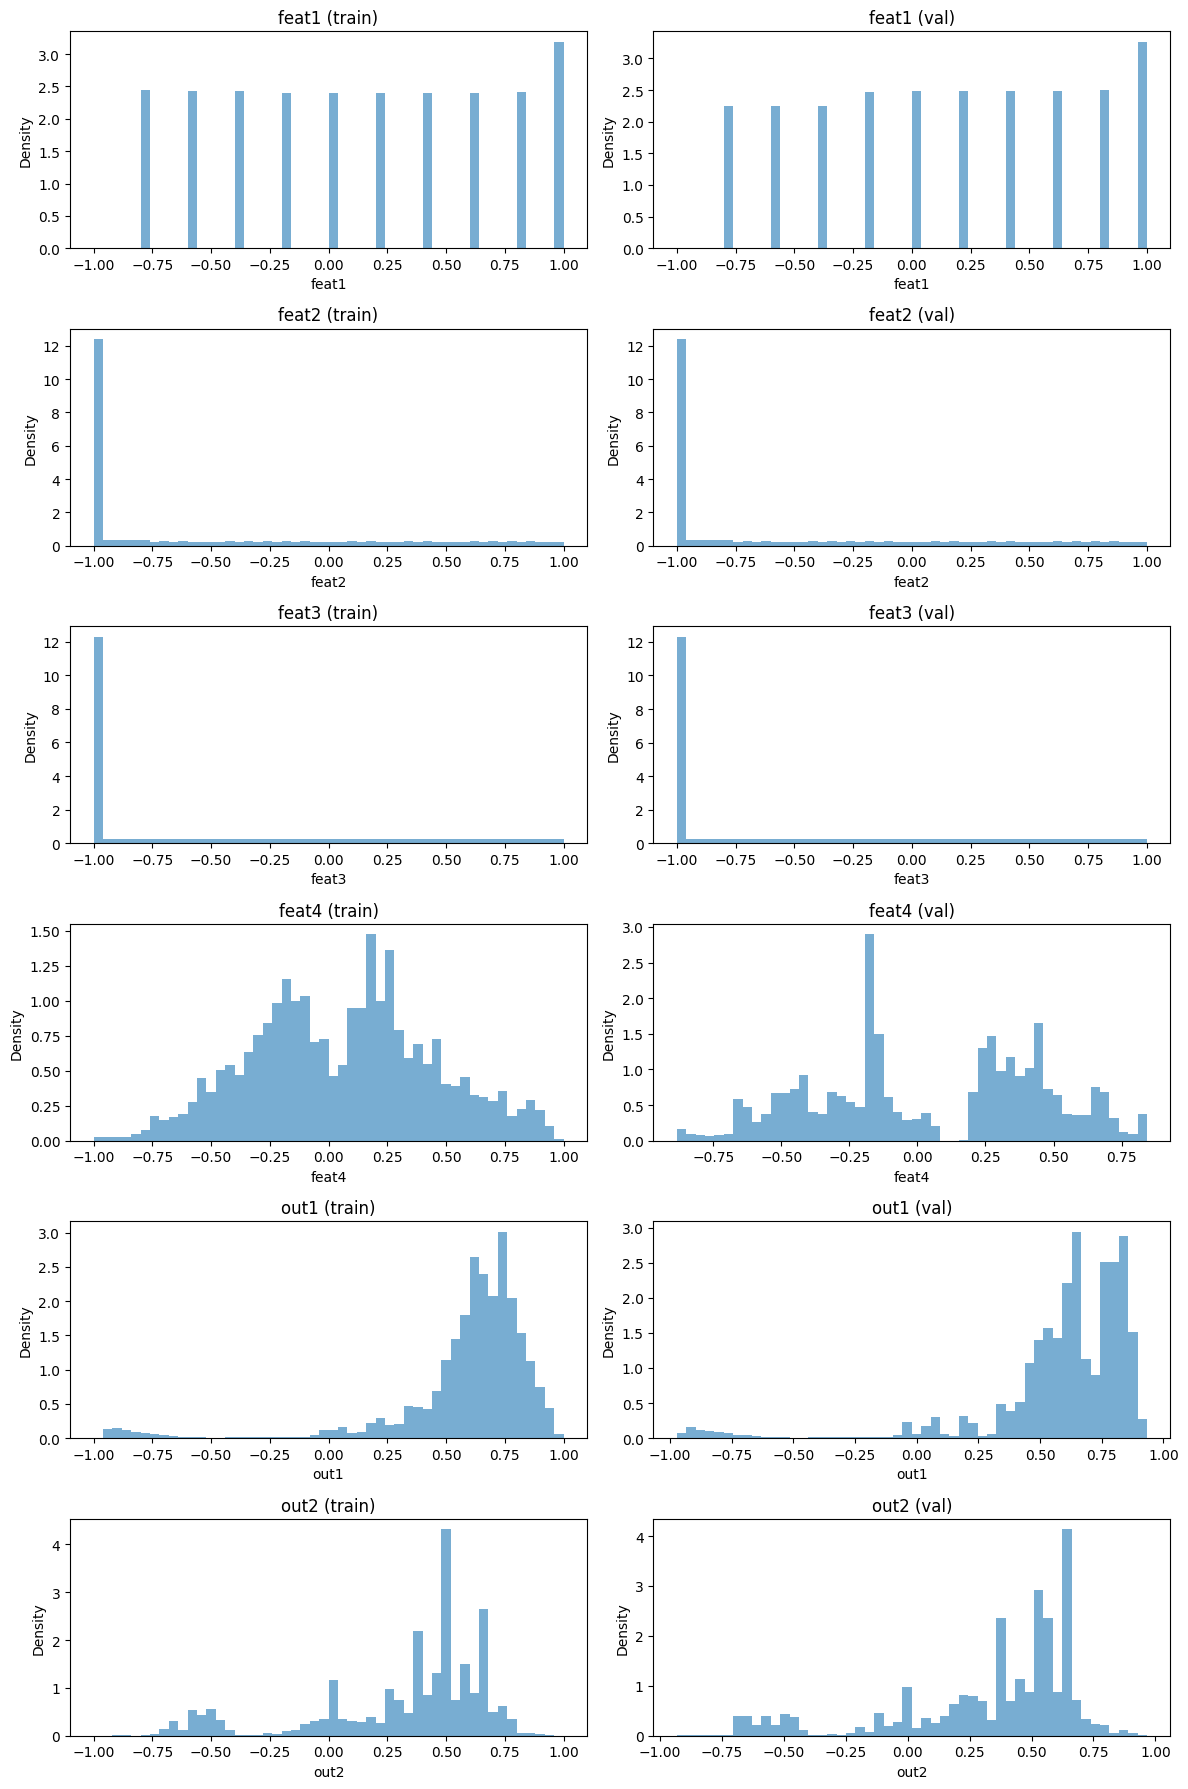

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 첫 타임스텝 데이터 NumPy 변환
train_x0 = x_past_train[:, 0, :].cpu().numpy()
val_x0   = x_past_val[:,   0, :].cpu().numpy()
train_y0 = y_past_train[:, 0, :].cpu().numpy()
val_y0   = y_past_val[:,   0, :].cpu().numpy()

# 2) 그릴 변수와 데이터 묶음 만들기
features = [
    ('feat1', train_x0[:,0], val_x0[:,0]),
    ('feat2', train_x0[:,1], val_x0[:,1]),
    ('feat3', train_x0[:,2], val_x0[:,2]),
    ('feat4', train_x0[:,3], val_x0[:,3]),
    ('out1',  train_y0[:,0], val_y0[:,0]),
    ('out2',  train_y0[:,1], val_y0[:,1]),
]

# 3) 6×2 subplot 생성 (가로 2, 세로 6)
fig, axes = plt.subplots(6, 2, figsize=(12, 18), tight_layout=True)

# 4) 각 변수마다 왼쪽(train), 오른쪽(val) 그리기
for i, (name, data_tr, data_val) in enumerate(features):
    ax_tr = axes[i, 0]
    ax_val= axes[i, 1]
    
    bins = 50
    ax_tr.hist(data_tr, bins=bins, density=True, alpha=0.6)
    ax_tr.set_title(f'{name} (train)')
    ax_tr.set_xlabel(name)
    ax_tr.set_ylabel('Density')
    
    ax_val.hist(data_val, bins=bins, density=True, alpha=0.6)
    ax_val.set_title(f'{name} (val)')
    ax_val.set_xlabel(name)
    ax_val.set_ylabel('Density')

plt.show()


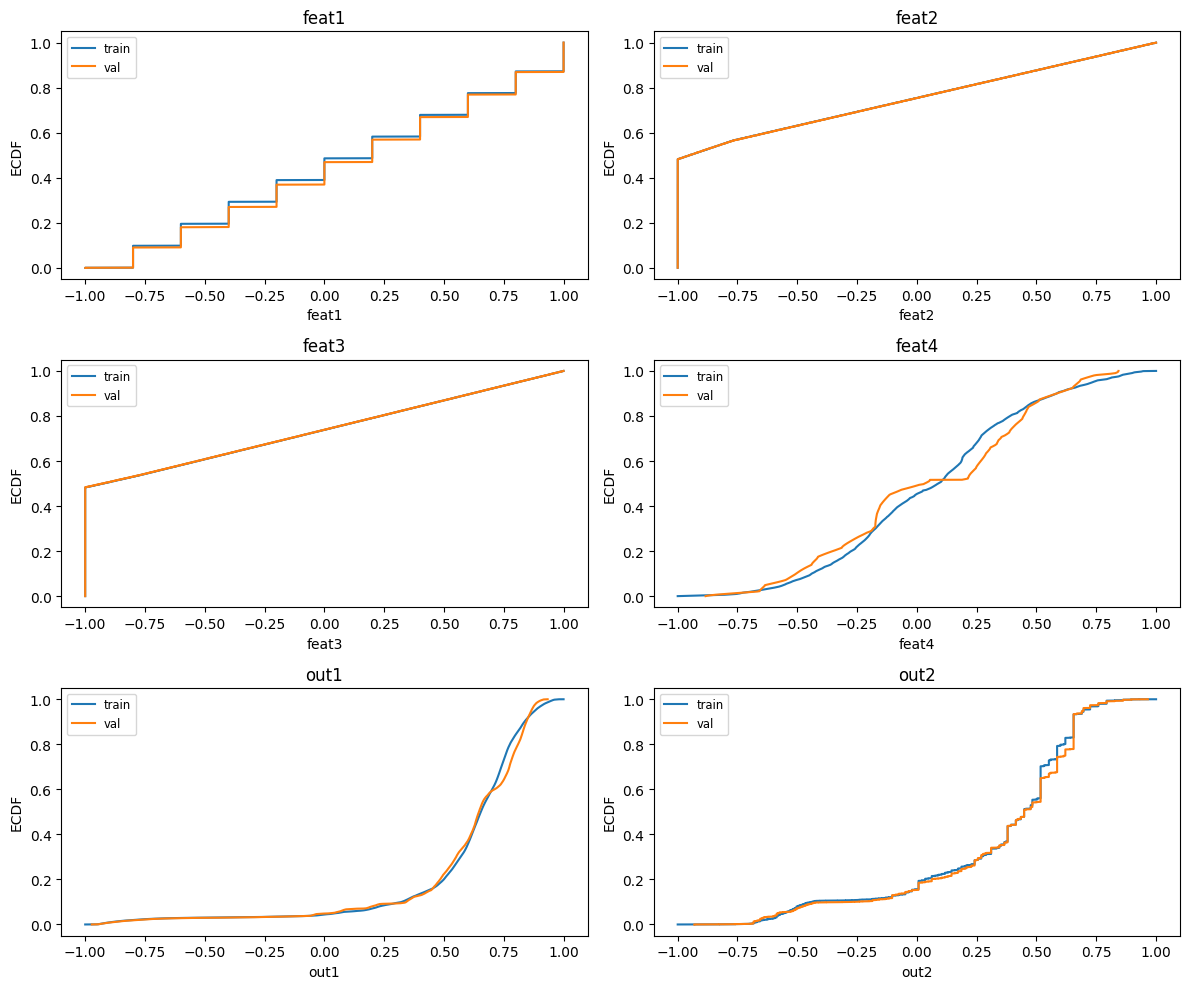

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# 첫 번째 타임스텝 NumPy 변환 (이전과 동일)
train_x0 = x_past_train[:, 0, :].cpu().numpy()
val_x0   = x_past_val[:,   0, :].cpu().numpy()
train_y0 = y_past_train[:, 0, :].cpu().numpy()
val_y0   = y_past_val[:,   0, :].cpu().numpy()

features = [
    ('feat1', train_x0[:,0], val_x0[:,0]),
    ('feat2', train_x0[:,1], val_x0[:,1]),
    ('feat3', train_x0[:,2], val_x0[:,2]),
    ('feat4', train_x0[:,3], val_x0[:,3]),
    ('out1',  train_y0[:,0], val_y0[:,0]),
    ('out2',  train_y0[:,1], val_y0[:,1]),
]

def plot_ecdf(ax, data_tr, data_val, name):
    tr_sorted = np.sort(data_tr)
    val_sorted = np.sort(data_val)
    ecdf_tr = np.arange(1, tr_sorted.size+1) / tr_sorted.size
    ecdf_val = np.arange(1, val_sorted.size+1) / val_sorted.size
    ax.plot(tr_sorted, ecdf_tr, label='train')
    ax.plot(val_sorted, ecdf_val, label='val')
    ax.set_title(name)
    ax.set_xlabel(name)
    ax.set_ylabel('ECDF')
    ax.legend(fontsize='small')

# 3×2 figure
fig, axes = plt.subplots(3, 2, figsize=(12, 10), tight_layout=True)

for ax, (name, dtr, dval) in zip(axes.flat, features):
    plot_ecdf(ax, dtr, dval, name)

plt.show()


## Prediction model (Tide) import

In [99]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())
print(f'Total number of parameters: {total_params}')
print(TiDE)

# Extract model dimensions
input_chunk_length = TiDE.input_chunk_length
output_chunk_length = TiDE.output_chunk_length
input_dim = TiDE.input_dim
output_dim = TiDE.output_dim
past_cov_dim = TiDE.past_cov_dim
future_cov_dim = TiDE.future_cov_dim
static_cov_dim = TiDE.static_cov_dim
nr_params = TiDE.nr_params

print("input_chunk_length:", input_chunk_length)
print("output_chunk_length:", output_chunk_length)
print("input_dim:", input_dim)
print("output_dim:", output_dim)
print("past_cov_dim:", past_cov_dim)
print("future_cov_dim:", future_cov_dim)
print("static_cov_dim:", static_cov_dim)
print("nr_params:", nr_params)

# Generate dummy input
B = 1  # batch size
x_past = torch.randn(B, input_chunk_length, input_dim)
x_future_covariates = torch.randn(B, output_chunk_length, future_cov_dim) if future_cov_dim > 0 else None
x_static_covariates = torch.randn(B, static_cov_dim) if static_cov_dim > 0 else None

# Move to device
x_past = x_past.to(device)
if x_future_covariates is not None:
    x_future_covariates = x_future_covariates.to(device)
if x_static_covariates is not None:
    x_static_covariates = x_static_covariates.to(device)

# Run model
x_in = (x_past, x_future_covariates, x_static_covariates)
y = TiDE(x_in)

# Print shapes
print("Input shape:")
print("  x_past:", x_past.shape)
if x_future_covariates is not None:
    print("  x_future_covariates:", x_future_covariates.shape)
if x_static_covariates is not None:
    print("  x_static_covariates:", x_static_covariates.shape)

print("Output shape:", y.shape)  # (B, output_chunk_length, output_dim, nr_params)

Total number of parameters: 796594
TideModule(
  (future_cov_projection): ResidualBlock(
    (dense): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=4, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (skip): Linear(in_features=4, out_features=4, bias=True)
    (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
  (encoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (skip): Linear(in_features=500, out_features=128, bias=True)
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=128, out_features=128,

## Execution function define

In [100]:
def plot_val_sample_policy_TiDE(k, model, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, u_shift, u_past_shift, c_shift, device, title="", model_name="", ax_list=None):
    model.eval()
    TiDE.eval()

    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)

        x_past[:,:,3] = x_past[:,:,3] + u_past_shift  # Shift the first feature (e.g., loc_Z)

        y_past = val_y_past[k:k+1].to(device)

        y_past[:,:,1] = y_past[:,:,1] + c_shift  # Shift the depth signal
        
        x_future = val_x_future[k:k+1].to(device)
        y_ref = val_y_ref[k:k+1].to(device)
        y_const = val_y_const[k:k+1].to(device)

        policy_in_past = torch.cat((x_past, y_past), dim=2)
        policy_in_fut = torch.cat((x_future, y_ref, y_const), dim=2)
        u_pred = model((policy_in_past, policy_in_fut))  # [1, P, 1]
        
        u_pred = u_pred + u_shift  # Shift the control signal


        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    u_pred = u_pred.squeeze(0).cpu().numpy()                      # [P, 1]
    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()     # [P, 2] (50% quantile)
    y_ref = y_ref.squeeze(0).cpu().numpy()                       # [P, 2]
    y_past = y_past.squeeze(0).cpu().numpy()                     # [window, 2]
    x_past_np = x_past[0].cpu().numpy()                          # [window, 4]

    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    control_past = x_past_np[:, 3]
    control_all = np.concatenate([control_past, u_pred.squeeze(-1)])

    # 2. Subplot 준비
    if ax_list is None:
        fig, ax_list = plt.subplots(3, 1, figsize=(8, 12))

    # Plot 1: Control
    ax_list[0].plot(np.arange(100), control_all[:], label="Control (past + predicted)")
    ax_list[0].axvline(49, color='gray', linestyle='--', linewidth=1)
    ax_list[0].set_ylabel("Control")
    ax_list[0].grid()
    ax_list[0].legend()

    # Plot 2: Temp
    ax_list[1].plot(time_past, y_past[:, 0], label="Temp (past)")
    ax_list[1].plot(time_future, y_ref[:, 0], '--', label="Temp (ref)")
    ax_list[1].plot(time_future, y_pred[:, 0], label="Temp (pred)")
    ax_list[1].set_ylabel("Temperature")
    ax_list[1].grid()
    ax_list[1].legend()

    # Plot 3: Depth
    ax_list[2].plot(time_past, y_past[:, 1], label="Depth (past)")
    # ax_list[2].plot(time_future, y_ref[:, 1], '--', label="Depth (ref)")  # optional
    ax_list[2].plot(time_future, y_pred[:, 1], label="Depth (pred)")
    ax_list[2].set_xlabel("Time")
    ax_list[2].set_ylabel("Depth")
    ax_list[2].grid()
    ax_list[2].legend()

    # 타이틀 (공통 super title은 외부 루프에서 관리할 수 있음)
    ax_list[0].set_title(f"{title} #{k}\n{model_name}")

    # Difference 계산 및 출력
    abs_diff = np.abs(y_pred - y_ref)  # [P, 2]
    mae = np.mean(abs_diff, axis=0)
    mse = np.mean((y_pred - y_ref) ** 2, axis=0)
    rmse = np.sqrt(mse)

    print(f"Sample #{k}, Model: {model_name}")
    print(f"  Temp  MAE: {mae[0]:.4f}, RMSE: {rmse[0]:.4f}")
    print(f"  Depth MAE: {mae[1]:.4f}, RMSE: {rmse[1]:.4f}")


## Import Policy

In [101]:
import os
import torch
from policy import PolicyNN

def load_multiple_policy_models(model_specs, device='cpu', base_dir="/home/ftk3187/github/DPC_research/02_DED/2_policy/trainresults"):
    """
    Load multiple PolicyNN models from a list of specs.
    Each spec: [date (str), n_layers (int), hidden_dim (int), s (float), c (float)]
    Returns: dict mapping from filename stem to loaded model
    """
    loaded_models = {}

    for spec in model_specs:
        date, text, n_layers, hidden_dim, s, c = spec
        filename = f"policy_model_{date}_{text}_{n_layers}L_{hidden_dim}H_s{s}_c{c}.pth"
        filepath = os.path.join(base_dir, filename)

        # 모델 생성
        model = PolicyNN_a(
            past_input_dim=6,
            future_input_dim=6,
            output_dim=1,
            p=50,
            window=50,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dropout_p=0.1
        ).to(device)

        # 모델 로드
        state_dict = torch.load(filepath, map_location=device)
        if isinstance(state_dict, dict) and "state_dict" in state_dict:
            state_dict = state_dict["state_dict"]
        model.load_state_dict(state_dict)
        model.eval()

        # 저장
        model_key = f"{date}_{text}_{n_layers}L_{hidden_dim}H_s{s}_c{c}"
        loaded_models[model_key] = model

    return loaded_models


## *** Execute policy ***

torch.Size([60942, 50, 1])
torch.Size([60942, 50, 4])
torch.Size([60942, 50, 2])
torch.Size([500, 50, 1])
torch.Size([500, 50, 4])
torch.Size([500, 50, 2])


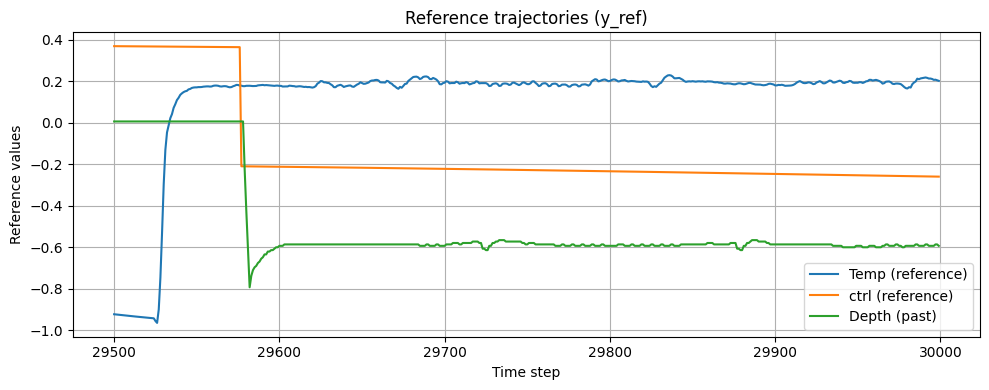

In [102]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_val_seq.shape)
print(x_past_val.shape)
print(y_past_val.shape)
start_idx = 29500
window = 30000-start_idx
y_ref_slice = y_ref_val_seq[start_idx : start_idx + window]
x_past_slice = x_past_val[start_idx : start_idx + window]
y_past_slice = y_past_val[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_ref_slice[:, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Sample #29600, Model: 0716_epoch100_3L_1024H_s2_c2
  Temp  MAE: 0.0086, RMSE: 0.0094
  Depth MAE: 0.7660, RMSE: 0.7660
Sample #29600, Model: 0702_epoch50_3L_1024H_s2_c2
  Temp  MAE: 0.0086, RMSE: 0.0094
  Depth MAE: 0.7665, RMSE: 0.7665


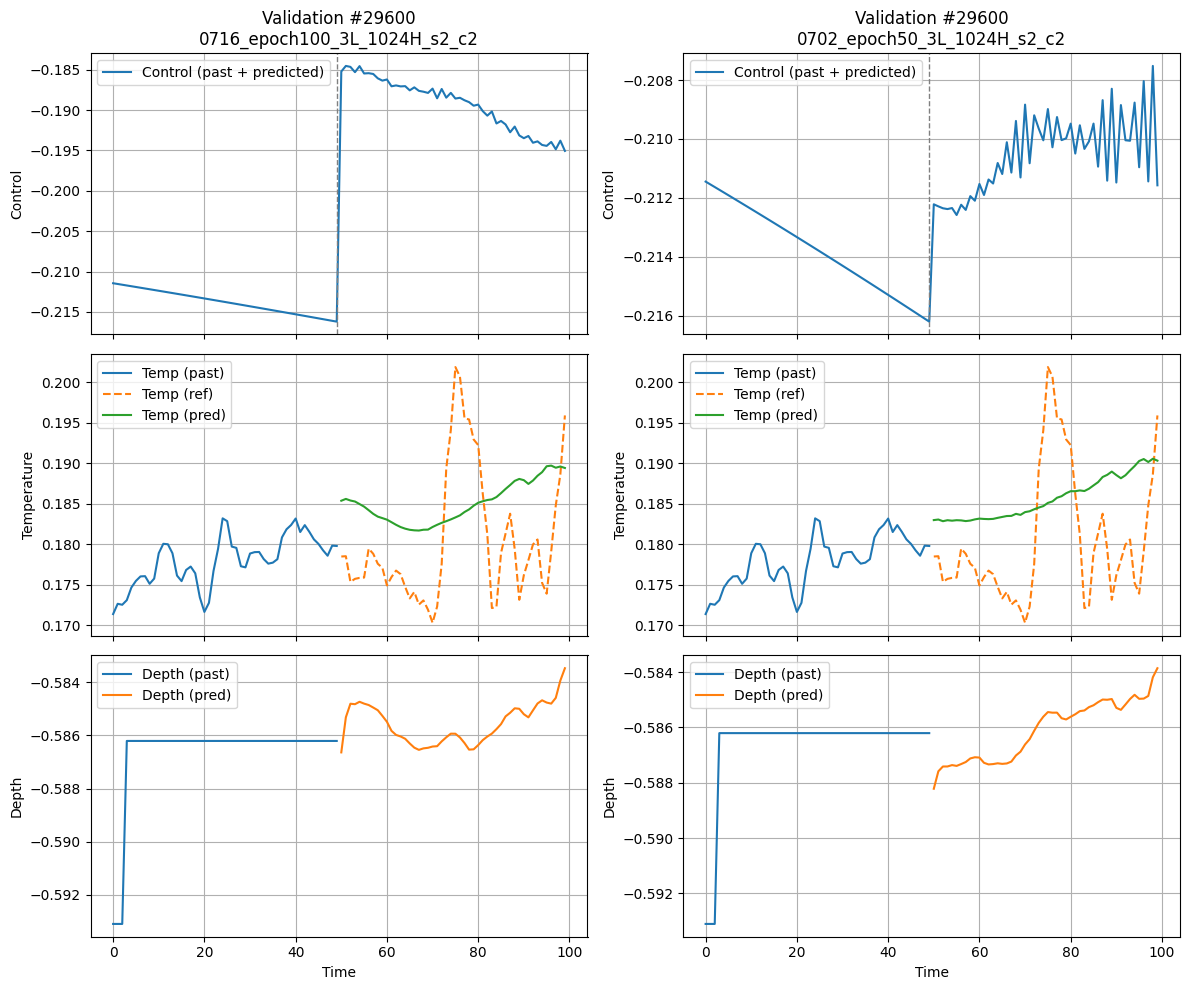

In [107]:
# 모델 사양 리스트
model_specs = [
    ["0716", "epoch100", 3, 1024, 2, 2],
    ["0702", "epoch50", 3, 1024, 2, 2]
]

# 모델 불러오기
models = load_multiple_policy_models(model_specs, device=device)

n_models = len(models)
fig, axs = plt.subplots(3, n_models, figsize=(6 * n_models, 10), sharex=True)

for col, (key, model) in enumerate(models.items()):
    ax_list = [axs[row][col] for row in range(3)]

    plot_val_sample_policy_TiDE(
        k=29600,
        model=model,
        TiDE=TiDE,
        val_x_past=x_past_val,
        val_y_past=y_past_val,
        val_x_future=x_future_val,
        val_y_ref=y_ref_val_seq,
        val_y_const=y_const_val_seq,
        u_past_shift = 0,
        u_shift = 0,
        c_shift = 0,
        device=device,
        title="Validation",
        model_name=key,
        ax_list=ax_list
    )

plt.tight_layout()
plt.show()


sd

In [104]:
def plot_val_sample_policy_orig(k, model, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, device, title="", model_name=""):
    model.eval()
    TiDE.eval()

    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)
        y_past = val_y_past[k:k+1].to(device)
        x_future = val_x_future[k:k+1].to(device)
        y_ref = val_y_ref[k:k+1].to(device)
        y_const = val_y_const[k:k+1].to(device)

        policy_in_past = torch.cat((x_past, y_past), dim=2)
        policy_in_fut = torch.cat((x_future, y_ref, y_const), dim=2)
        u_pred = val_x_past[k+50:k+51].to(device)
        u_pred = u_pred[:, :, 3].to(device)  # Control input from past data
        u_pred = u_pred.unsqueeze(-1)
        # u_pred = model((policy_in_past, policy_in_fut))  # [1, P, 1]


        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    u_pred = u_pred.squeeze(0).cpu().numpy()                      # [P, 1]
    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()     # [P, 2] (50% quantile)
    y_ref = y_ref.squeeze(0).cpu().numpy()                       # [P, 2]
    y_past = y_past.squeeze(0).cpu().numpy()                     # [window, 2]
    x_past_np = x_past[0].cpu().numpy()                          # [window, 4]

    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    plt.figure(figsize=(12, 10))

    # Plot 1: Control
    plt.subplot(3, 1, 1)
    control_past = x_past_np[:, 3]
    control_all = np.concatenate([control_past, u_pred.squeeze(-1)])
    plt.plot(np.arange(100), control_all, label="Control (past + predicted)")
    plt.axvline(49, color='gray', linestyle='--', linewidth=1)
    plt.ylabel("Control")
    plt.grid()
    plt.legend()

    # Plot 2: Temp
    plt.subplot(3, 1, 2)
    plt.plot(time_past, y_past[:, 0], label="Temp (past)")
    plt.plot(time_future, y_ref[:, 0], '--', label="Temp (ref)")
    plt.plot(time_future, y_pred[:, 0], label="Temp (pred)")
    plt.ylabel("Temperature")
    plt.grid()
    plt.legend()

    # Plot 3: Depth
    plt.subplot(3, 1, 3)
    plt.plot(time_past, y_past[:, 1], label="Depth (past)")
    # plt.plot(time_future, y_ref[:, 1], '--', label="Depth (ref)")
    plt.plot(time_future, y_pred[:, 1], label="Depth (pred)")
    plt.xlabel("Time")
    plt.ylabel("Depth")
    plt.grid()
    plt.legend()

    plt.suptitle(f"{title} sample #{k}, model: {model_name}")
    plt.tight_layout()
    plt.show()

    # Difference 계산 및 출력
    abs_diff = np.abs(y_pred - y_ref)  # [P, 2]
    mae = np.mean(abs_diff, axis=0)
    mse = np.mean((y_pred - y_ref) ** 2, axis=0)
    rmse = np.sqrt(mse)

    print(f"Sample #{k}, Model: {model_name}")
    print(f"  Temp  MAE: {mae[0]:.4f}, RMSE: {rmse[0]:.4f}")
    print(f"  Depth MAE: {mae[1]:.4f}, RMSE: {rmse[1]:.4f}")


torch.Size([60942, 50, 1])
torch.Size([60942, 50, 4])
torch.Size([60942, 50, 2])
torch.Size([9000, 50, 1])
torch.Size([9000, 50, 4])
torch.Size([9000, 50, 2])


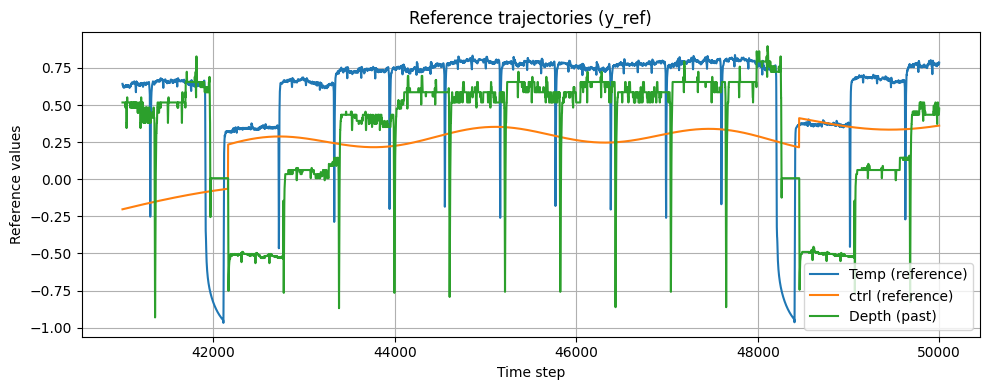

In [105]:
import matplotlib.pyplot as plt
import numpy as np

print(y_ref_val_seq.shape)
print(x_past_val.shape)
print(y_past_val.shape)
start_idx = 41000
window = 50000-start_idx
y_ref_slice = y_ref_val_seq[start_idx : start_idx + window]
x_past_slice = x_past_val[start_idx : start_idx + window]
y_past_slice = y_past_val[start_idx : start_idx + window]
print(y_ref_slice.shape)
print(x_past_slice.shape)
print(y_past_slice.shape)


time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_ref_slice[:, 0], label="Temp (reference)")
plt.plot(time_future, x_past_slice[:, 0, 3], label="ctrl (reference)")
plt.plot(time_future, y_past_slice[:, 0, 1], label="Depth (past)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
def plot_val_sample_policy_orig(k, model, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, device, title="", model_name=""):
    model.eval()
    TiDE.eval()

    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)
        y_past = val_y_past[k:k+1].to(device)
        x_future = val_x_future[k:k+1].to(device)
        y_ref = val_y_ref[k:k+1].to(device)
        y_const = val_y_const[k:k+1].to(device)

        policy_in_past = torch.cat((x_past, y_past), dim=2)
        policy_in_fut = torch.cat((x_future, y_ref, y_const), dim=2)
        u_pred = val_x_past[k+50:k+51].to(device)
        u_pred = u_pred[:, :, 3].to(device)  # Control input from past data
        u_pred = u_pred.unsqueeze(-1)
        # u_pred = model((policy_in_past, policy_in_fut))  # [1, P, 1]


        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    u_pred = u_pred.squeeze(0).cpu().numpy()                      # [P, 1]
    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()     # [P, 2] (50% quantile)
    y_ref = y_ref.squeeze(0).cpu().numpy()                       # [P, 2]
    y_past = y_past.squeeze(0).cpu().numpy()                     # [window, 2]
    x_past_np = x_past[0].cpu().numpy()                          # [window, 4]

    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    plt.figure(figsize=(12, 10))

    # Plot 1: Control
    plt.subplot(3, 1, 1)
    control_past = x_past_np[:, 3]
    control_all = np.concatenate([control_past, u_pred.squeeze(-1)])
    plt.plot(np.arange(100), control_all, label="Control (past + predicted)")
    plt.axvline(49, color='gray', linestyle='--', linewidth=1)
    plt.ylabel("Control")
    plt.grid()
    plt.legend()

    # Plot 2: Temp
    plt.subplot(3, 1, 2)
    plt.plot(time_past, y_past[:, 0], label="Temp (past)")
    plt.plot(time_future, y_ref[:, 0], '--', label="Temp (ref)")
    plt.plot(time_future, y_pred[:, 0], label="Temp (pred)")
    plt.ylabel("Temperature")
    plt.grid()
    plt.legend()

    # Plot 3: Depth
    plt.subplot(3, 1, 3)
    plt.plot(time_past, y_past[:, 1], label="Depth (past)")
    # plt.plot(time_future, y_ref[:, 1], '--', label="Depth (ref)")
    plt.plot(time_future, y_pred[:, 1], label="Depth (pred)")
    plt.xlabel("Time")
    plt.ylabel("Depth")
    plt.grid()
    plt.legend()

    plt.suptitle(f"{title} sample #{k}, model: {model_name}")
    plt.tight_layout()
    plt.show()

    # Difference 계산 및 출력
    abs_diff = np.abs(y_pred - y_ref)  # [P, 2]
    mae = np.mean(abs_diff, axis=0)
    mse = np.mean((y_pred - y_ref) ** 2, axis=0)
    rmse = np.sqrt(mse)

    print(f"Sample #{k}, Model: {model_name}")
    print(f"  Temp  MAE: {mae[0]:.4f}, RMSE: {rmse[0]:.4f}")
    print(f"  Depth MAE: {mae[1]:.4f}, RMSE: {rmse[1]:.4f}")
